- Read data
- ID text col
* Vectorize
- Cluster
- Make column by assigining docs to cluster
- Write to csv
- ...
- DR ->
- Create project
- Upload data
- Ensure cluster feature is categorical?
- Run, compare to metrics without cluster

In [50]:
import pandas as pd
import numpy as np
import datarobot as dr
import topic_model
import os
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Cluster the data (based on text data and NMF in this case)

In [51]:
# Read the data file
file_path = 'data/'
file_name = '10kDiabetes'
file_extn = '.csv'
df = pd.read_csv(file_path + file_name + file_extn)
df[df.diag_1_desc.isnull()].shape

(2, 52)

### Cluster - topic model dibetes dataset

['Spinal',
 'stenosis',
 'in',
 'cervical',
 'region',
 'Spinal',
 'stenosis',
 'in',
 'cervical',
 'region',
 'Effusion',
 'of',
 'joint,',
 'site',
 'unspecified']

In [98]:
# For unsupervised topic modeling, we need text fields to cluster.
# The diabetes dataset has three unstructured text fields that comprise doctor/nurse/staff notes about the patient.
# We'll use this to cluster, and aggregate all three into one feature.

def make_docs(df, text_cols):    
    '''
    For each feature column in the dataframe, tokenize the words then combine each column
    into one pandas series
    
    Parameters:
        df - your dataframe
        text_colums - the colums to tokenize and aggregate
    
    Return:
        docs - a pandas series of text data
    '''
    text_col_data = []
    for col in text_cols:
        series = df[col]

        # tokenize the words in each text feature
        series = series.apply(lambda x: x.split() if type(x) == str else [])

        # Combine into one feature
        text_col_data.append(series)

    combined_cols = text_col_data[0]
    for i in range(1, len(text_col_data)):
        combined_cols = combined_cols + text_col_data[i]

    docs = combined_cols.apply(lambda x: ' '.join(x))
    
    return docs

text_columns = [
#     'diag_1_desc', 'diag_2_desc', 'diag_3_desc',  # diabetes
    'diag_1_desc', 'diag_2_desc', 'diag_3_desc',  # lending club
]  # diabetes

docs = make_docs(df, text_columns)

# There should be no null rows
print('Null rows:',docs[docs.isnull()].shape[0])
print('Not null:  %s' % docs[docs.notnull()].shape[0])

Null rows: 0
Not null:  10000


In [97]:
docs.head()

0    Spinal stenosis in cervical region Spinal sten...
1    First-degree perineal laceration, unspecified ...
2    Pneumococcal pneumonia [Streptococcus pneumoni...
3    Cellulitis and abscess of face Streptococcus i...
4    Bipolar I disorder, single manic episode, unsp...
dtype: object

In [54]:
# Params to build the vocab and topics
min_df = 10
max_df = .1
max_vocab_size = 5000
ngram_range=(1,1)

tm = topic_model.NMF_TopicModeller(max_vocab_size=max_vocab_size, 
                                   min_df=min_df, 
                                   max_df=max_df, 
                                   ngram_range=ngram_range)
tm.vectorize(docs)

Number of documents to process: 10000

Extracting Vectorizer features...
- Time: 0.206s.



Processed NMF for k=20 of 20 - Time: 0.897s.
No existing word2vec model found to load. Exception: [Errno 2] No such file or directory: './data/w2v-model.bin'.
Building it...
- Time: 1.737s.
Saving it...
word2vec model has 583 terms
Calculating coherence scores...
Optimal number of k topics: 19


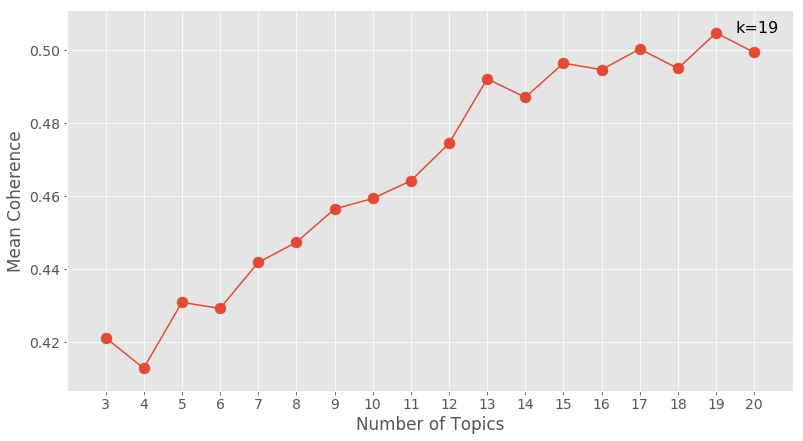

Topic 00: stage, hypertensive, ckd, renal, aorta, manifestations, anemia, septicemia, streptococcal, hemorrhage, sideroblastic, circulatory, peripheral, implant, mechanical
Topic 01: myocardial, wall, anterolateral, old, collapse, pulmonary, abuse, alcohol, ckd, atrioventricular, block, complete, hypertensive, nervous, asthma
Topic 02: abnormality, respiratory, cardiospasm, achalasia, obesity, asthma, extrinsic, situ, alcohol, abuse, old, joint, region, spinal, anxiety
Topic 03: syndrome, postmyocardial, basilar, artery, chiari, budd, raynaud, postcholecystectomy, cor, pulmonale, nervous, allergic, hypertensive, juvenile, shock
Topic 04: infection, urinary, tract, streptococcus, septicemia, streptococcal, conditions, coli, intestinal, bladder, prostate, colic, intussusception, luts, symptom
Topic 05: pneumonia, organism, asthma, extrinsic, pneumoniae, collapse, pulmonary, klebsiella, streptococcal, septicemia, influenza, trachea, pneumococcal, pleurisy, emphysematous
Topic 06: obstruct

In [55]:
# Calculate the optimal k using word2vec for coherence metric
k_topics = topic_model.plot_optimal_k(docs.tolist(), tm.document_term_mat, tm.vectorizer,
                           kmin=3, kmax=20, dim_size=500, min_df=min_df, 
                           max_vocab_size=max_vocab_size, num_top_terms=15,
                           model_file_path='./data/',
                           model_file_name='w2v-model.bin')

In [56]:
tm.fit(docs, k_topics=k_topics)

Fitting model with 10000 documents.  Vectorizer: 
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=5000, min_df=10,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'and', 'wherein', 'but', 'jx', 'con', 'few', 'yy', 'empty', 'xg', 'oo', 'ob', 'w', 'neither', 'bw', 'as', 'ql', 'mine', 'en', 'yk', 'wx', 'bc', 'bs', 'dv', 'xb', 'five', 'pt', 'wd', 'until', 'please', 'down', 'pm', 'a', 'anything', 'fg', 'jo', 'du', 'rs', 'ry', 'bottom', 'ow', ...m', 'md', 'qz', 'already', 'yf', 'ec', 'sk', 'te', 'xm', 'lz', 'qa', 'day', 'ki', 'me', 'zk', 'nx'}),
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?ui)\\b[a-zA-Z]*[a-z]+\\w*\\b', tokenizer=None,
        use_idf=True, vocabulary=None)
- Time: 1.052s.



In [57]:
# Generate the probability of each topic for each row (eg, job posting)
# and add the top topic and probability to the dataframe
def get_normalized_probs(topic_weights):
    '''
    Return the normalized topic cluseter weights for a given row
    '''
    topic_weights = topic_weights.flatten()
    #print row_idx
    if topic_weights.sum() == 0:
        probs = topic_weights
    else:
        probs = (topic_weights / topic_weights.sum())
    return probs

# For each row, get the topic weights, normalize, order by
# weight value, and store in a list to add to the dataframe 
top_topics = []
top_topic_weights = []
for row_idx in range(tm.W.shape[0]):
    W = tm.W[row_idx]
    probs = get_normalized_probs(W)
    
    ordered_idxs = np.argsort(probs)[::-1]
    top_topics.append(ordered_idxs[0])
    top_topic_weights.append(probs[ordered_idxs[0]])
    
df['top_topic'] = top_topics
df['top_topic_weight'] = top_topic_weights

In [58]:
tm.W[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00413187, 0.        , 0.01372072,
       0.        , 0.        , 0.        , 0.01700684])

In [59]:
df.head()

,rowID,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc,top_topic,top_topic_weight
0,1,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,...,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified",8,0.632077
1,2,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,...,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia,18,0.487869
2,3,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,...,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia,5,0.916534
3,4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,...,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...,7,0.725775
4,5,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,...,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis,12,1.000000


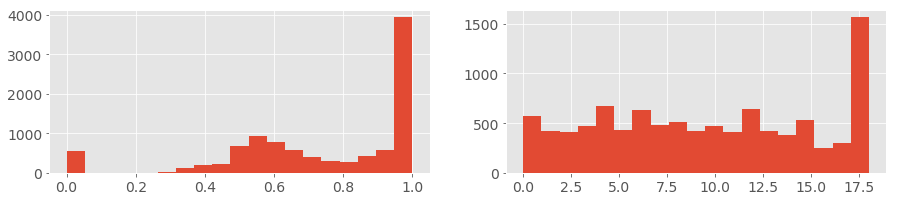

In [60]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
df.top_topic_weight.hist(bins=k_topics, ax=axs[0])
df.top_topic.hist(bins=k_topics, ax=axs[1])

Topic probabilities:
[0.00000000e+00 0.00000000e+00 3.76472616e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.32077370e-01 0.00000000e+00 0.00000000e+00 3.67546158e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]

Top Topic: 8

Spinal stenosis in cervical region


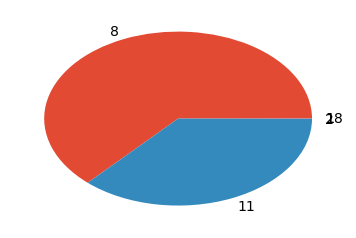

In [61]:
# Inspect record data
def inspect_record(rec_id):
    row_num = rec_id
    probs = get_normalized_probs(tm.W[row_num])
    ordered_idxs = np.argsort(probs)[::-1]
    top_topic = ordered_idxs[0]
    print ("Topic probabilities:\n%s\n" % probs)
    print ("Top Topic: %s\n" % top_topic)
#     print ("Top Tags:\n%s\n" % get_topic_top_tags(top_topic, 3))

    top_topics.append(ordered_idxs[0])
    top_topic_weights.append(probs[ordered_idxs[0]])
    plt.pie(probs[ordered_idxs[:5]], labels=ordered_idxs[:5])
    print (df.iloc[row_num].diag_1_desc)
inspect_record(0)

In [62]:
df.columns

Index(['rowID', 'race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_desc', 'diag_2_desc', 'diag_3_desc', 'top_topic',
       'top_topic_weight'],
      dtype='object')

In [18]:
file_with_topics = file_path + file_name + '_with_topics' + file_extn
df.to_csv(file_with_topics)

# Create a new DataRobot project with the new dataset with cluster features

In [17]:
dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint=os.environ['DATAROBOT_ENDPOINT'])

In [19]:
# # Create a project: and upload the data, set the target, give the project a name
project = dr.Project.create(sourcedata=file_with_cluster, 
                            project_name='Diabetes with cluster')

print('project id:  ', project.id)
print('project name:', project.project_name)
print('project.get_status():\n- ', project.get_status())

project id:   5b0319116cd83a72e74df751
project name: Diabetes with cluster
project.get_status():
-  {'autopilot_done': False, 'stage_description': 'Ready to set target', 'stage': 'aim'}


In [20]:
# Output the identified project features# Outpu 
features = project.get_features()
sorted([f.name for f in features])

['A1Cresult',
 'Unnamed: 0',
 'acarbose',
 'acetohexamide',
 'admission_source_id',
 'admission_type_id',
 'age',
 'change',
 'chlorpropamide',
 'citoglipton',
 'diabetesMed',
 'diag_1',
 'diag_1_desc',
 'diag_2',
 'diag_2_desc',
 'diag_3',
 'diag_3_desc',
 'discharge_disposition_id',
 'examide',
 'gender',
 'glimepiride',
 'glimepiride_pioglitazone',
 'glipizide',
 'glipizide_metformin',
 'glyburide',
 'glyburide_metformin',
 'insulin',
 'max_glu_serum',
 'medical_specialty',
 'metformin',
 'metformin_pioglitazone',
 'metformin_rosiglitazone',
 'miglitol',
 'nateglinide',
 'num_lab_procedures',
 'num_medications',
 'num_procedures',
 'number_diagnoses',
 'number_emergency',
 'number_inpatient',
 'number_outpatient',
 'payer_code',
 'pioglitazone',
 'race',
 'readmitted',
 'repaglinide',
 'rosiglitazone',
 'rowID',
 'time_in_hospital',
 'tolazamide',
 'tolbutamide',
 'top_topic',
 'top_topic_weight',
 'troglitazone',
 'weight']

In [21]:
# Convert top topic to a categorical variable
new_feature = project.create_type_transform_feature(name='top_topic_cat', 
                                      parent_name='top_topic', 
                                      variable_type='categoricalInt')
new_feature

Feature(top_topic_cat)

In [22]:
# # Create a new feature list from our subset of features to eliminate target leaks
# # new_list = [c for c in df_less_5.columns] + [new_feature.name]
# new_list = ['DELAY_INDICATOR', 'ORIGIN', 'DESTINATION', 'CARRIER', 
#             'DAY_OF_WEEK', 'HOUR_OF_DPTR', 'ACT_AC_TYPE', new_feature.name]
# f_list = project.create_featurelist('No leaks list', new_list)
# f_list

In [24]:
# By calling set_target, we run datarobot
target='readmitted'
project.set_target(target=target, 
                   mode='auto',
                   worker_count=20)  # ,
#                    featurelist_id=f_list.id)

Project(Diabetes with cluster)

In [28]:
# Get the models, which are already ordered by rank from the leaderboard
models = project.get_models()

# Get the best performing model (excluding the blenders, which are typically the top 4 models)
best_model = models[4]
print('Best model from the leaderboard:\n\'%s\'' % best_model.model_type)
print()

# Get the blueprint
blueprint_id = best_model.blueprint_id
blueprint = dr.models.Blueprint.get(project.id, blueprint_id)
print('Best model blueprint preprocessing steps:')
pprint(blueprint.processes)
print()

# Get the model scoring metrics
print('Best model metrics:')
pprint(best_model.metrics)

Best model from the leaderboard:
'ExtraTrees Classifier (Gini)'

Best model blueprint preprocessing steps:
['One-Hot Encoding',
 'Univariate credibility estimates with ElasticNet',
 'Converter for Text Mining',
 'Auto-Tuned Word N-Gram Text Modeler using token occurrences',
 'Missing Values Imputed',
 'Search for differences',
 'Search for ratios',
 'Feature Selection for dimensionality reduction',
 'ExtraTrees Classifier (Gini)']

Best model metrics:
{'AUC': {'backtesting': None,
         'backtestingScores': None,
         'crossValidation': 0.7017960000000001,
         'holdout': None,
         'validation': 0.71914},
 'FVE Binomial': {'backtesting': None,
                  'backtestingScores': None,
                  'crossValidation': 0.091758,
                  'holdout': None,
                  'validation': 0.10514},
 'Gini Norm': {'backtesting': None,
               'backtestingScores': None,
               'crossValidation': 0.403592,
               'holdout': None,
         

In [9]:
import time
for f in range(10):
    print(f, end='\r', flush=True)
    time.sleep(1)

9
